In [8]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.arima import ARIMASummary
from statsforecast.models import SeasonalNaive, AutoTBATS, MSTL, AutoMFLES, AutoTheta

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [6]:
plt.rcParams['figure.figsize'] = (9,6)

## Theta

In [12]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/monthly-milk-production-pounds.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month']+'-01')+pd.offsets.MonthEnd(1)
df['Month'] = df['Month'].dt.date
df = df.rename(columns={"Month": "Date", "Monthly milk production (pounds per cow)": "y"})
df.insert(0, 'unique_id', 1)

df.head()

,unique_id,Date,y
0,1,1962-01-31,589
1,1,1962-02-28,561
2,1,1962-03-31,640
3,1,1962-04-30,656
4,1,1962-05-31,727


In [15]:
theta = AutoTheta(season_length=24,
                  decomposition_type='additive',
                  alias='Theta')

sf = StatsForecast(models=[theta], freq='M')
cv_df = sf.cross_validation(h=12, 
                            df=df, 
                            n_windows=5, 
                            step_size=12, 
                            time_col='Date')

cv_df.head()

,unique_id,Date,cutoff,y,Theta
0,1,1971-01-31,1970-12-31,804.0,773.326
1,1,1971-02-28,1970-12-31,756.0,733.287
2,1,1971-03-31,1970-12-31,860.0,824.212
3,1,1971-04-30,1970-12-31,878.0,842.769
4,1,1971-05-31,1970-12-31,942.0,904.612


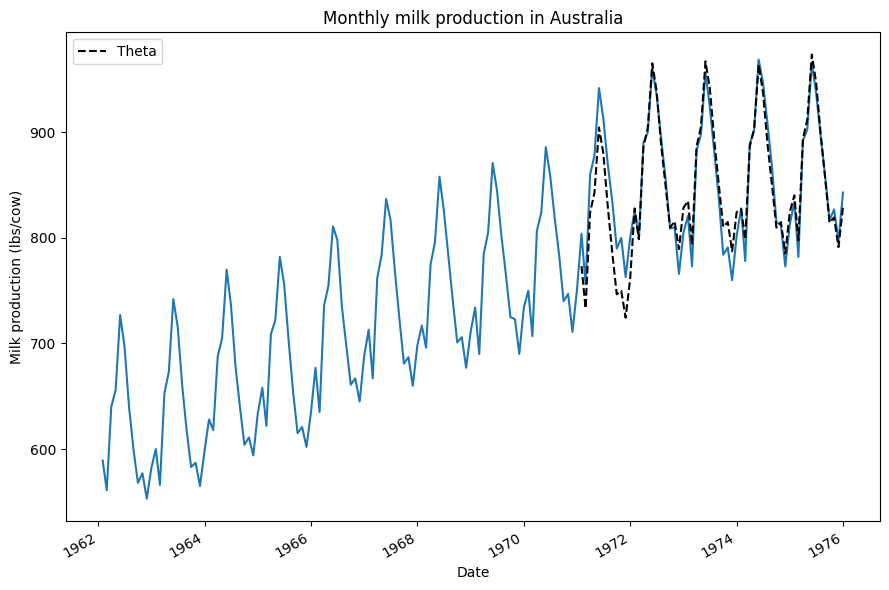

In [16]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['Theta'], label='Theta', ls='--', color='black')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [17]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape])
avg_evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
avg_evaluation

,metric,Theta
0,mae,15.501
1,smape,0.009


## TBATS

In [19]:
url = "https://raw.githubusercontent.com/marcopeix/time-series-analysis/refs/heads/master/data/daily_traffic.csv"

df = pd.read_csv(url, parse_dates=["date_time"])
df.insert(0, 'unique_id', 1)
df.head()

,unique_id,date_time,traffic_volume
0,1,2016-09-29 17:00:00,5551.0
1,1,2016-09-29 18:00:00,4132.0
2,1,2016-09-29 19:00:00,3435.0
3,1,2016-09-29 20:00:00,2765.0
4,1,2016-09-29 21:00:00,2443.0


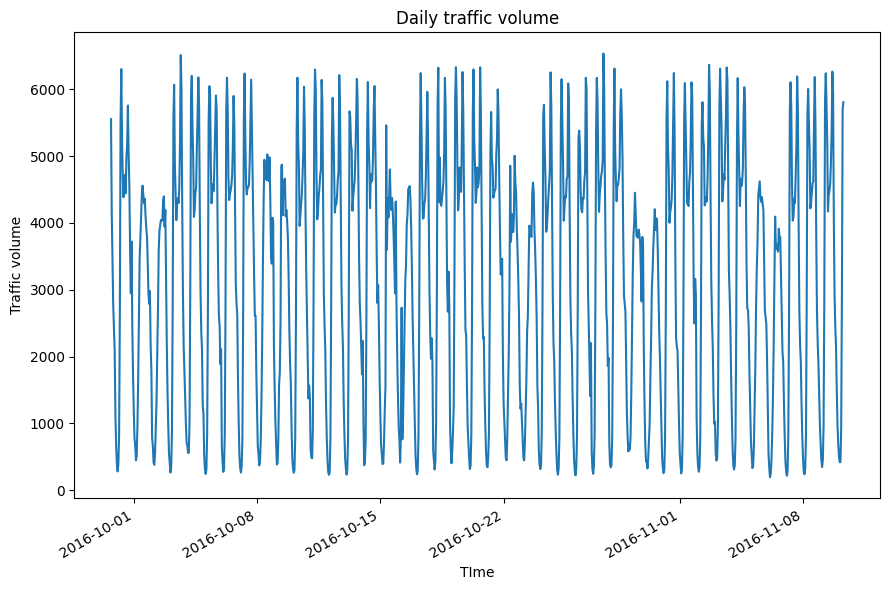

In [20]:
fig, ax = plt.subplots()

ax.plot(df['date_time'], df['traffic_volume'])
ax.set_xlabel('TIme')
ax.set_ylabel('Traffic volume')
ax.set_title('Daily traffic volume')

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
h = 24

seasonal_naive = SeasonalNaive(season_length=24, alias='naive')
tbats = AutoTBATS(season_length=[24, 168],
                  use_boxcox=False,
                  use_arma_errors=True,
                  alias='TBATS')

sf = StatsForecast(models=[seasonal_naive, tbats], freq='H')
cv_df = sf.cross_validation(h=h, 
                            df=df, 
                            n_windows=10, 
                            step_size=h, 
                            time_col='date_time',
                            target_col='traffic_volume')

cv_df.head()

,unique_id,date_time,cutoff,traffic_volume,naive,TBATS
0,1,2016-10-31 08:00:00,2016-10-31 07:00:00,5108.0,1692.0,5296.092
1,1,2016-10-31 09:00:00,2016-10-31 07:00:00,4795.0,2276.0,4221.521
2,1,2016-10-31 10:00:00,2016-10-31 07:00:00,4002.0,3014.0,3813.848
3,1,2016-10-31 11:00:00,2016-10-31 07:00:00,4160.0,3277.0,3970.675
4,1,2016-10-31 12:00:00,2016-10-31 07:00:00,4230.0,3644.0,4095.540


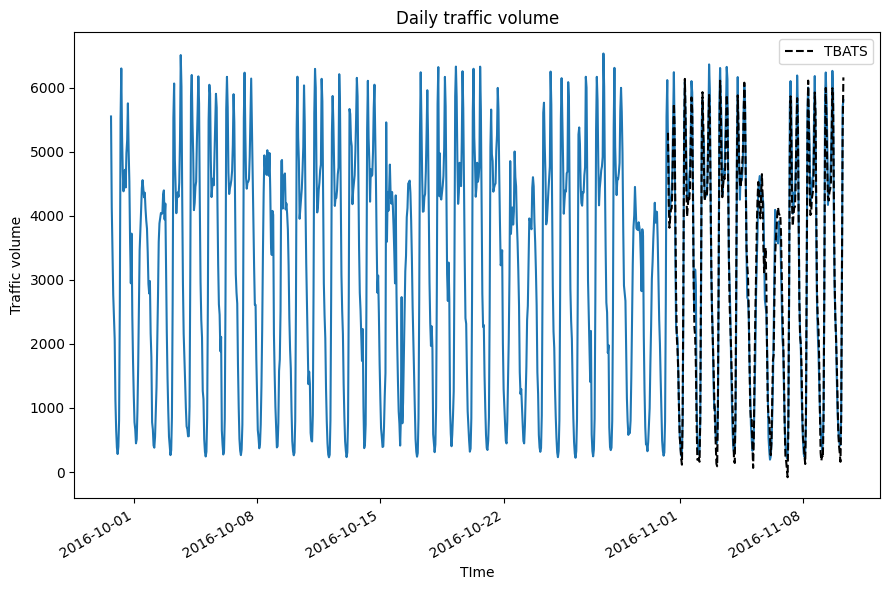

In [27]:
fig, ax = plt.subplots()

ax.plot(df['date_time'], df['traffic_volume'])
ax.plot(cv_df['date_time'], cv_df['TBATS'], ls='--', color='black', label='TBATS')
ax.set_xlabel('TIme')
ax.set_ylabel('Traffic volume')
ax.set_title('Daily traffic volume')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
eval_df = cv_df.drop(['date_time', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='traffic_volume')
evaluation

,unique_id,metric,naive,TBATS
0,1,mae,467.725,242.977
1,1,smape,0.097,0.083


## MSTL

In [28]:
mstl = MSTL(season_length=[24, 168],
            alias='MSTL')

sf = StatsForecast(models=[mstl], freq='H')
mstl_cv_df = sf.cross_validation(h=h, 
                            df=df, 
                            n_windows=10, 
                            step_size=h, 
                            time_col='date_time',
                            target_col='traffic_volume')

mstl_cv_df.head()

,unique_id,date_time,cutoff,traffic_volume,MSTL
0,1,2016-10-31 08:00:00,2016-10-31 07:00:00,5108.0,5024.983
1,1,2016-10-31 09:00:00,2016-10-31 07:00:00,4795.0,4422.788
2,1,2016-10-31 10:00:00,2016-10-31 07:00:00,4002.0,3794.139
3,1,2016-10-31 11:00:00,2016-10-31 07:00:00,4160.0,4046.801
4,1,2016-10-31 12:00:00,2016-10-31 07:00:00,4230.0,4128.555


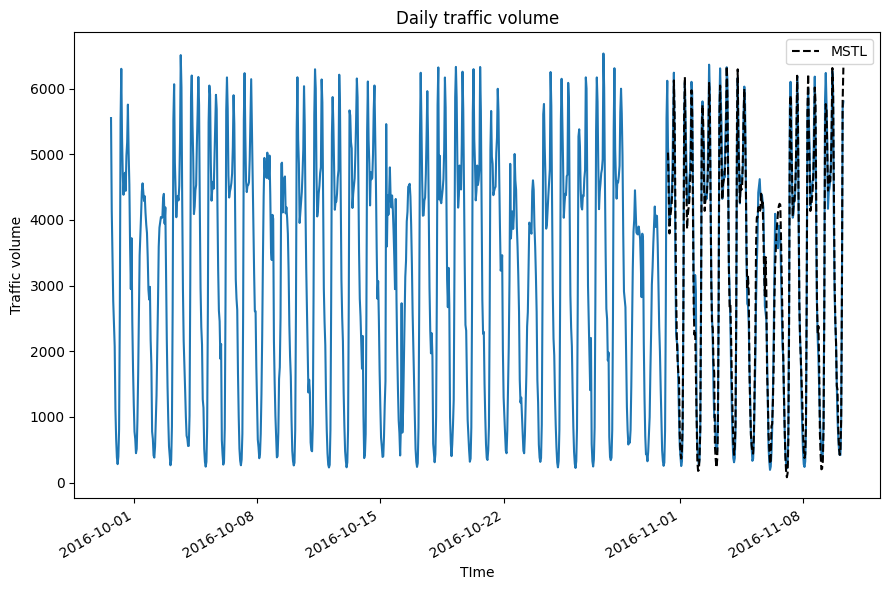

In [29]:
fig, ax = plt.subplots()

ax.plot(df['date_time'], df['traffic_volume'])
ax.plot(mstl_cv_df['date_time'], mstl_cv_df['MSTL'], ls='--', color='black', label='MSTL')
ax.set_xlabel('TIme')
ax.set_ylabel('Traffic volume')
ax.set_title('Daily traffic volume')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
eval_df['MSTL'] = mstl_cv_df['MSTL'].values
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='traffic_volume')
evaluation

,unique_id,metric,naive,TBATS,MSTL
0,1,mae,467.725,242.977,223.709
1,1,smape,0.097,0.083,0.067


## MFLES

In [37]:
mfles = AutoMFLES(test_size=24,
                  season_length=[24, 168],
                  n_windows=3,
                  metric='smape',
                  alias='MFLES')

sf = StatsForecast(models=[mfles], freq='H')
mfles_cv_df = sf.cross_validation(h=h, 
                            df=df, 
                            n_windows=10, 
                            step_size=h, 
                            time_col='date_time',
                            target_col='traffic_volume')

mfles_cv_df.head()

,unique_id,date_time,cutoff,traffic_volume,MFLES
0,1,2016-10-31 08:00:00,2016-10-31 07:00:00,5108.0,5332.169
1,1,2016-10-31 09:00:00,2016-10-31 07:00:00,4795.0,5196.203
2,1,2016-10-31 10:00:00,2016-10-31 07:00:00,4002.0,4626.238
3,1,2016-10-31 11:00:00,2016-10-31 07:00:00,4160.0,4484.358
4,1,2016-10-31 12:00:00,2016-10-31 07:00:00,4230.0,4249.883


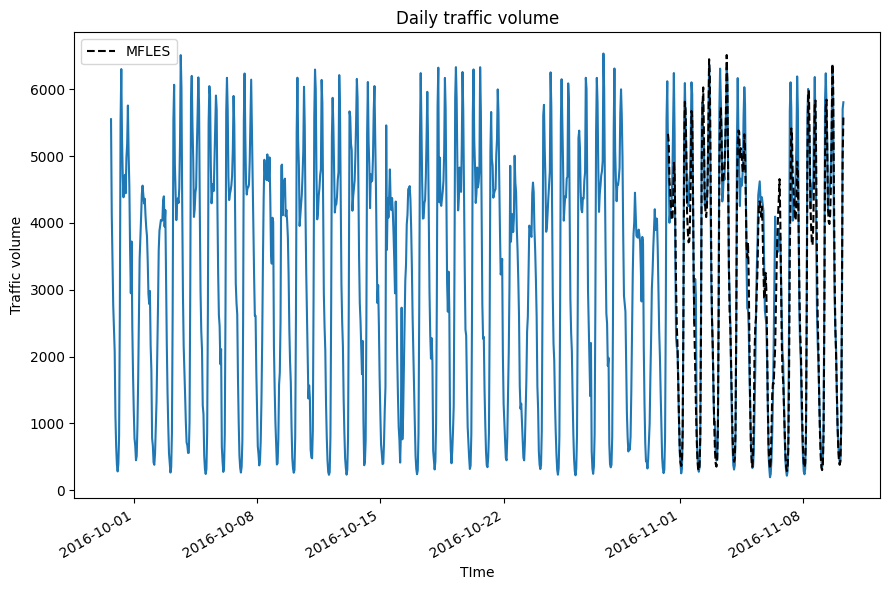

In [39]:
fig, ax = plt.subplots()

ax.plot(df['date_time'], df['traffic_volume'])
ax.plot(mfles_cv_df['date_time'], mfles_cv_df['MFLES'], ls='--', color='black', label='MFLES')
ax.set_xlabel('TIme')
ax.set_ylabel('Traffic volume')
ax.set_title('Daily traffic volume')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [41]:
eval_df['MFLES'] = mfles_cv_df['MFLES'].values
evaluation = evaluate(df=eval_df, metrics=[mae, smape], target_col='traffic_volume')
evaluation

,unique_id,metric,naive,TBATS,MSTL,MFLES
0,1,mae,467.725,242.977,223.709,353.977
1,1,smape,0.097,0.083,0.067,0.071
